In [6]:
import numpy as np
import matplotlib.pyplot as plt



class InfoBottle:
    
    def __init__(self,px,py_x,nt):
        assert(px.shape[0]==py_x.shape[1])
        self.px = px/np.sum(px)
        self.py_x = py_x/np.sum(py_x,axis=0)[np.newaxis,:]
        
        self.nx = px.shape[0]
        self.ny = py_x.shape[0]
        self.nt = nt
        
        self.pt_x = np.empty((self.nt,self.nx))
        self.pt = np.empty(self.nt)
        self.py_t = np.empty((self.ny,self.nt))
        
        self.initialize_distributions()
        
        
    def initialize_distributions(self,pt_x=None,pt=None,py_t=None,seed=None):
        if seed is not None:
            np.random.seed(seed)
            
        if pt_x is None:
            self.pt_x = np.random.rand(self.nt,self.nx)
            self.pt_x = self.pt_x/np.sum(self.pt_x,axis=0)[np.newaxis,:]
        if pt is None:
            self.pt = np.random.rand(self.nt)
            self.pt = self.pt/np.sum(self.pt)
        if py_t is None:
            self.py_t = np.random.rand(self.ny,self.nt)
            self.py_t = self.py_t/np.sum(self.py_t,axis=0)[np.newaxis,:]
            
    def dtx(self,py_x,py_t):
    
        return np.einsum('yx,yxt->tx',py_x,np.log(np.einsum('yx,yt->yxt',py_x,1/py_t)))

    
    def getrandomInitialCondition(self,seed=None):
        if seed is not None:
            np.random.seed(seed)

        pt_x = np.random.rand(self.nt,self.nx)
        pt_x = pt_x/np.sum(pt_x,axis=0)[np.newaxis,:]
        pt = np.random.rand(self.nt)
        pt = pt/np.sum(pt)
        py_t = np.random.rand(self.ny,self.nt)
        py_t = py_t/np.sum(py_t,axis=0)[np.newaxis,:]
        
        return pt_x, pt, py_t
    
    def convMeasure(self,x,y,tol=1e-5):
        #return np.sum(np.abs(x - y))<tol
        return np.allclose(x,y,rtol=tol) 
        
    
    def runInfoBottleneck(self,num_steps=1,beta=0,iterations=1,tol=0.01,randomic=True,seed=None,verbose=False):
        
        if seed is not None:
            np.random.seed(seed)
        
        for i in range(iterations):
            
            if randomic:                
                pt_x, pt, py_t = self.getrandomInitialCondition()

            for step in range(num_steps):

                if step>0:
                    if self.convMeasure(pt_x,past_pt_x,tol) and self.convMeasure(py_t,past_py_t,tol):
                        if verbose:
                            print("Converged")
                        break

                past_pt_x = np.copy(pt_x)
                past_pt   = np.copy(pt)
                past_py_t = np.copy(py_t)     

                args = np.log(past_pt[:,np.newaxis]) - beta*self.dtx(self.py_x,past_py_t)
                #expd = past_pt[:,np.newaxis]*np.exp(-beta*dtx(py_x,past_py_t))
                #args = args - np.max(args)
                expd = np.exp(args)
                z = np.sum(expd,axis=0)       
                pt_x = expd[:,:]/z[np.newaxis,:]

                pt = np.sum(pt_x[:,:]*self.px[np.newaxis,:],axis=1)
                px_t = (pt_x[:,:]*self.px[np.newaxis,:]/pt[:,np.newaxis])
                py_t = np.einsum('yx,tx->yt',self.py_x,px_t)
                
            if i==0:
                minL = self.ITX(self.px,pt_x,pt) - beta*self.ITY(py_t,pt)
                self.pt_x = pt_x
                self.pt = pt
                self.py_t = py_t
            else:
                L = self.ITX(self.px,pt_x,pt) - beta*self.ITY(py_t,pt)
                if L < minL:
                    minL = L
                    self.pt_x = pt_x
                    self.pt = pt
                    self.py_t = py_t

        
    def ITX(self,px=None,pt_x=None,pt=None):
        
        if px is None or pt_x is None or pt is None:
            return np.sum(self.px[np.newaxis,:]*self.pt_x[:,:]*(np.log(self.pt_x[:,:]) - np.log(self.pt[:,np.newaxis])))
        else:
            return np.sum(px[np.newaxis,:]*pt_x[:,:]*(np.log(pt_x[:,:]) - np.log(pt[:,np.newaxis])))

    def ITY(self,py_t=None,pt=None):
        
        if py_t is None or pt is None:
            py = np.sum(self.py_t[:,:]*self.pt[np.newaxis,:],axis=1)   
            return np.sum(self.pt[np.newaxis,:]*self.py_t[:,:]*(np.log(self.py_t[:,:]) - np.log(py[:,np.newaxis])))
        else:
            py = np.sum(py_t[:,:]*pt[np.newaxis,:],axis=1)   
            return np.sum(pt[np.newaxis,:]*py_t[:,:]*(np.log(py_t[:,:]) - np.log(py[:,np.newaxis])))
        
    def scanBeta(self,num_betas=50,min_beta=0,max_beta=20,num_steps=1000,iterations=1,seed=None,tol=1e-8,makefig=True,savefig=False,delta=None):
        betas = np.linspace(min_beta,max_beta,num_betas)
        itx = np.empty(num_betas)
        ity = np.empty(num_betas)
        
        for ib,beta in enumerate(betas):
            self.runInfoBottleneck(num_steps=num_steps,beta=beta,iterations=iterations,seed=seed,tol=tol,verbose=False)
            itx[ib] = self.ITX()
            ity[ib] = self.ITY()
        
        if makefig:
            plt.figure()
            if delta is not None:
                plt.title(r"$\delta = $"+str(delta)+r", $|\tilde{X}| = $"+str(nt))
            plt.xlabel(r"$\beta$")
            plt.ylabel(r"$I$")
            plt.plot(betas,itx,label=r"$I(X;\tilde{X})$")
            plt.plot(betas,ity,label=r"$I(Y;\tilde{X})$")
            plt.legend()
            if savefig:
                plt.savefig("figs/iversusbeta_d"+str(int(100*delta))+"_nt"+str(self.nt)+".png")

            plt.figure()
            if delta is not None:
                plt.title(r"$\delta = $"+str(delta)+r", $|\tilde{X}| = $"+str(nt))
            plt.xlabel(r"$\beta$")
            plt.ylabel(r"$\mathcal{L}$")
            plt.plot(betas,itx - beta*ity,label="$\mathcal{L}$")
            plt.legend()
            if savefig:
                plt.savefig("figs/Lversusbeta_d"+str(int(100*delta))+"_nt"+str(self.nt)+".png")

            plt.figure()
            if delta is not None:
                plt.title(r"$\delta = $"+str(delta)+r", $|\tilde{X}| = $"+str(nt))
            plt.xlabel(r"$I(X;\tilde{X})$")
            plt.ylabel(r"$I(Y;\tilde{X})$")
            plt.plot(itx,ity)
            if savefig:
                plt.savefig("figs/iversusi_d"+str(int(100*delta))+"_nt"+str(self.nt)+".png")
        
        
class GenerateGrid:
    
    def __init__(self,edge_x,edge_z,delta):
        self.edge_x = edge_x
        self.edge_z = edge_z
        self.delta = delta
        
        self.num_xs = 2*self.edge_x + 1
        self.num_zs = 2*self.edge_z + 1
        self.num_total = self.num_xs*self.num_zs
        
        
        self.px = np.ones(self.num_total)/self.num_total
        self.px = self.px/np.sum(self.px)
        self.py_x = np.empty((2,self.num_total))
        
        for x in range(-self.edge_x,self.edge_x+1):
            for z in range(-self.edge_z,self.edge_z+1):
                if x*z>0:
                    self.py_x[1,self.index(x,z)] = 1 - self.delta
                    self.py_x[0,self.index(x,z)] = self.delta
                elif x*z<0:
                    self.py_x[1,self.index(x,z)] = self.delta
                    self.py_x[0,self.index(x,z)] = 1 - self.delta
                else:
                    self.py_x[1,self.index(x,z)] = 0.5
                    self.py_x[0,self.index(x,z)] = 0.5
                    
        self.xs = np.repeat(np.arange(-self.edge_x,self.edge_x+1),self.num_zs)
        self.zs = np.tile(np.arange(-self.edge_z,self.edge_z+1),self.num_xs)        
        
    def index(self,x,z):
        return (x+self.edge_x)*self.num_zs + (z+self.edge_z)
    
    
    def generateLabels(self,pt_x):
        self.labels = np.empty(self.num_total,dtype=int)
     
        for x in self.xs:
            for z in self.zs:
                ind = self.index(x,z)
                self.labels[ind] = np.argmax(pt_x[:,ind])
    
    def plotGrid(self,beta=None,nt=None,colours=None,savefig=False):

        if colours is None:
            colours = {0:'black',1: 'red', 2: 'blue', 3: 'yellow',4:'purple',5:'green'}

        fig, ax = plt.subplots(figsize=(3, 3))
        if beta is not None:
            plt.title(r"$\beta = $"+str(beta)+r", $\delta = $"+str(self.delta)+r", $|\tilde{X}| = $"+str(nt))
        for g in np.unique(self.labels):
            ix = np.where(self.labels == g)
            ax.scatter(self.xs[ix], self.zs[ix], c = colours[g], label = g, s = 10)
        #ax.legend()
        plt.gca().set_aspect('equal', adjustable='box')
        if savefig:
            plt.savefig("figs/gridB"+str(beta)+"d"+str(int(100*self.delta))+"nt"+str(nt))
        plt.show()
        
        

<>:151: SyntaxWarning: invalid escape sequence '\m'
<>:151: SyntaxWarning: invalid escape sequence '\m'
C:\Users\zijieh4\AppData\Local\Temp\ipykernel_15264\904614572.py:151: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(betas,itx - beta*ity,label="$\mathcal{L}$")


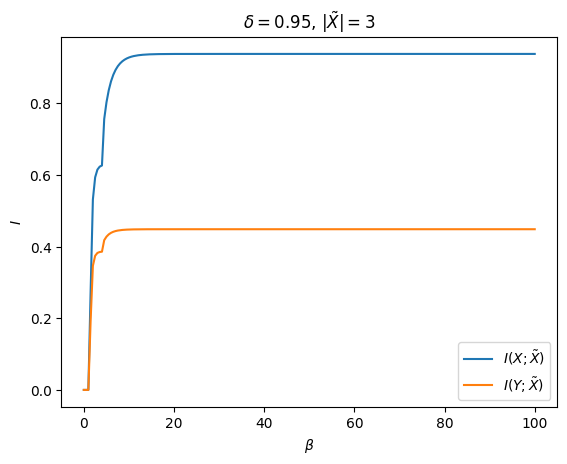

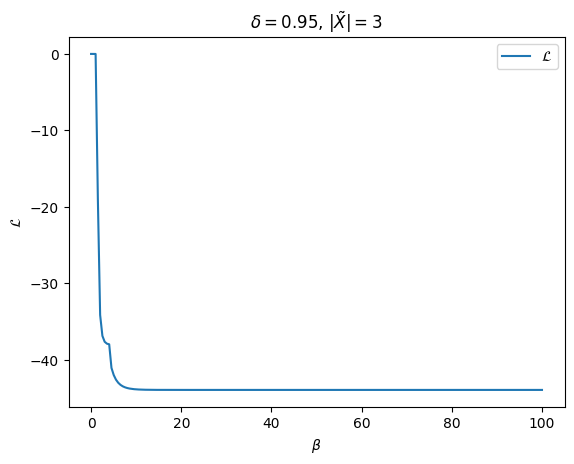

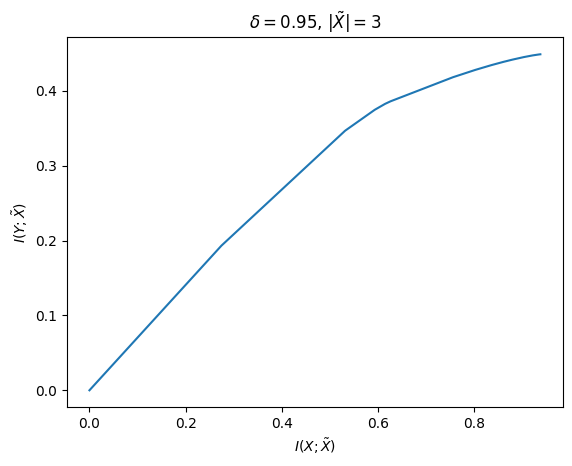

In [7]:
# run for delta = 0.55, 0.75, 0.99; nt = 2,3,5
delta = 0.95
nt = 3
g1 = GenerateGrid(10,10,delta)
ib1 = InfoBottle(g1.px,g1.py_x,nt=nt)
ib1.scanBeta(num_betas=200,min_beta=0,max_beta=100,num_steps=1000,iterations=1,seed=25,tol=1e-2,makefig=True,savefig=True,delta=delta)

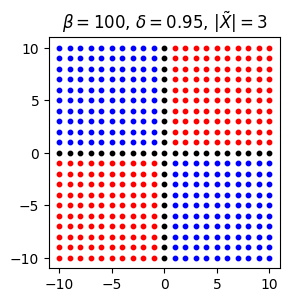

In [8]:
beta = 100
ib1.runInfoBottleneck(num_steps=100,beta=beta,iterations=1,seed=25)
g1.generateLabels(ib1.pt_x)
g1.plotGrid(beta,nt=nt,savefig=True)